# Final project of the 'Deep Learning for Computer vision and NLP' section

## Technical task

The task is to develop an efficient predictive model that can handle a large number of input features using the PetFinder.my database, the largest online pet adoption service in Malaysia, as an example.

The main goal of the final course project is to predict the adoption rate of pets based on their profiles on PetFinder.my.

The model predictions for the validation dataset are evaluated using the “quadratic weighted kappa” metric.

### 1. Data loading

In [45]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

In [3]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

Loading CSV

In [4]:
dataset_dir = "/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-12/"
train_df = pd.read_csv(dataset_dir + "train.csv")
test_df = pd.read_csv(dataset_dir + "test.csv")
sub = pd.read_csv(dataset_dir + "sample_submission.csv")

In [5]:
train_df.head()

,PetID,Description,AdoptionSpeed
0,d3b4f29f8,Mayleen and Flo are two lovely adorable sister...,2
1,e9dc82251,A total of 5 beautiful Tabbys available for ad...,2
2,8111f6d4a,Two-and-a-half month old girl. Very manja and ...,2
3,693a90fda,Neil is a healthy and active ~2-month-old fema...,2
4,9d08c85ef,Gray kitten available for adoption in sungai p...,2


In [6]:
test_df.head()

,PetID,Description
0,6697a7f62,This cute little puppy is looking for a loving...
1,23b64fe21,These 3 puppies was rescued from a mechanic sh...
2,41e824cbe,"Ara needs a forever home! Believe me, he's a r..."
3,6c3d7237b,i rescue this homeless dog 2 years ago but my ...
4,97b0b5d92,We found him at a shopping mall at a very clea...


In [7]:
sub.head()

,PetID,AdoptionSpeed
0,6697a7f62,1
1,23b64fe21,2
2,41e824cbe,3
3,6c3d7237b,4


Loading images

In [8]:
train_images_dir = dataset_dir + "images/images/train"
test_images_dir = dataset_dir + "images/images/test"

### 2. Data exploration

#### 2.1. Table data

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6431 entries, 0 to 6430
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   PetID          6431 non-null   object
 1   Description    6426 non-null   object
 2   AdoptionSpeed  6431 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 150.9+ KB


In [10]:
train_df.describe()

,AdoptionSpeed
count,6431.000000
mean,2.683719
std,1.118951
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


In [11]:
adoption_speed_counts_train = train_df["AdoptionSpeed"].value_counts().sort_index()
adoption_speed_counts_train

AdoptionSpeed
1    1197
2    1773
3    1328
4    2133
Name: count, dtype: int64

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PetID        1891 non-null   object
 1   Description  1890 non-null   object
dtypes: object(2)
memory usage: 29.7+ KB


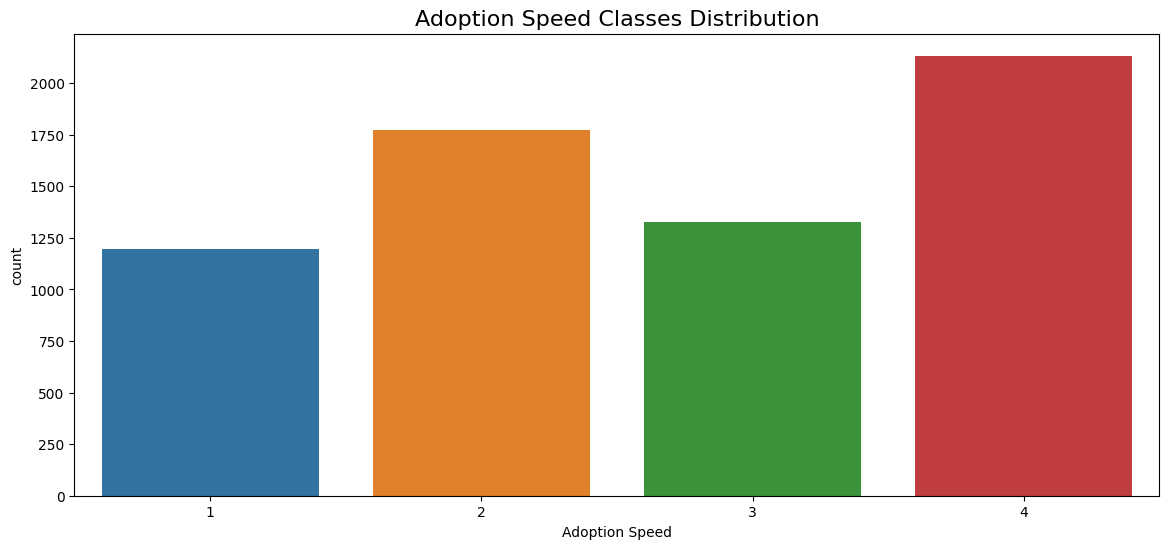

In [13]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="AdoptionSpeed", data=train_df)
plt.title("Adoption Speed Classes Distribution", fontsize=16)
plt.xlabel("Adoption Speed")
plt.show()

As can be seen from the previous analysis:
* Both the training and test datasets contain a small number of NaN values in the Description column. These gaps can be replaced with empty strings.
* The training dataset has an uneven distribution of classes (the number of class 4 is twice the number of class 1), which can affect the quality of the classifier. Class alignment should be introduced.
* In total, the training dataset contains just over six thousand data instances, which is a relatively small number, and it may be necessary to increase the data to improve the quality of the model.
* It is better to convert class labels (adoption speed) to string format to make them easier for the model to process.

#### 2.2. Images

Plot an example of a pet's image

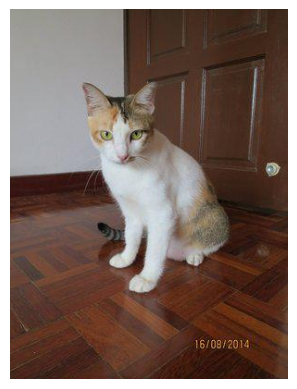

In [14]:
image_path = os.listdir(train_images_dir)[0]
image = mpimg.imread(train_images_dir + "/" + image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

Function to count images

In [15]:
def count_images(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])


train_imgs_count = count_images(train_images_dir)
test_imgs_count = count_images(test_images_dir)

print("Number of train images: ", train_imgs_count)
print("Number of test  images: ", test_imgs_count)

Number of train images:  28472
Number of test  images:  9448


There are many more pictures than pets, which means that some pets have multiple pictures. It may also be that some of them have no images at all.

Function to find pets without pictures

In [16]:
def find_pets_without_images(directory, df):
    photo_files = [file for file in os.listdir(directory) if file.endswith('.jpg')]
    photo_pet_ids = set(file.split("-")[0] for file in photo_files)
    dataset_pet_ids = set(df["PetID"])
    pet_ids_without_photos = dataset_pet_ids - photo_pet_ids
    return pet_ids_without_photos


train_pets_without_images = find_pets_without_images(train_images_dir, train_df)
test_pets_without_images = find_pets_without_images(test_images_dir, test_df)

print("Train pets without images: ", train_pets_without_images)
print("Test  pets without images: ", test_pets_without_images)

Train pets without images:  set()
Test  pets without images:  {'63521459', '35992662', '81301773', '95314294'}


In the training dataset, all pets have images, in the test dataset there are 4 animals without images, the model must be able to handle the data if the image or description of the pet is missing.

### 3. Data preparation

#### 3.1. Train-validation split

Filling NaN descriptions with empty strings because the tokenizer from the next step cannot handle NaN values

In [17]:
train_df["Description"] = train_df["Description"].fillna("")
test_df["Description"] = test_df["Description"].fillna("")

Сlass balancing

In [18]:
max_class_size = list(adoption_speed_counts_train)[-1]

train_balanced_df = pd.concat(
    [resample(train_df[train_df['AdoptionSpeed'] == cls], 
              replace=True, 
              n_samples=max_class_size, 
              random_state=random_seed) for cls in train_df['AdoptionSpeed'].unique()]
).reset_index(drop=True)

balanced_classes = train_balanced_df['AdoptionSpeed'].value_counts().sort_index()
balanced_classes

AdoptionSpeed
1    2133
2    2133
3    2133
4    2133
Name: count, dtype: int64

Split the train dataframe into train and validation dataframes

In [20]:
train_raw_df, val_raw_df = train_test_split(train_balanced_df, test_size=0.2, random_state=random_seed, stratify=train_balanced_df["AdoptionSpeed"])
train_raw_df.shape, val_raw_df.shape

((6825, 3), (1707, 3))

#### 3.2. Text preprocessing

Pretrained BERT tokenizer

In [46]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenization of pets descriptions using BERT tokenizer

In [47]:
def tokenize_descriptions(descriptions, max_length=128): # max_lgth - embedding dimension
    return tokenizer(
        list(descriptions),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )


train_tokens = tokenize_descriptions(train_raw_df["Description"])
val_tokens = tokenize_descriptions(val_raw_df["Description"])
test_tokens = tokenize_descriptions(test_df["Description"])

train_tokens[0:1]

[Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

Convert labels to 0-based indexing as requested by PyTorch

In [48]:
train_labels = torch.tensor(train_raw_df["AdoptionSpeed"].values - 1)
val_labels = torch.tensor(val_raw_df["AdoptionSpeed"].values - 1)

#### 3.3. Image Preprocessing

Image conversion with size unification, random transformations and standard normalization for jpg images

In [50]:
IMAGE_SIZE = (224, 224)
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
])

Function for preprocessing of all images for a given PetID (if no images exist, return a placeholder tensor)

In [ ]:
def preprocess_images(pet_id, base_folder):
    image_files = sorted(glob.glob(f"{base_folder}/{pet_id}-*.jpg"))
    if len(image_files) == 0: # Return a placeholder tensor if no images
        return torch.zeros((3, *IMAGE_SIZE))
    
    # Load and preprocess all images for the PetID
    images = [image_transforms(Image.open(img).convert("RGB")) for img in image_files]
    # Stack images and take the mean (simple aggregation)
    return torch.stack(images).mean(dim=0)

train_images = torch.stack([preprocess_images(pet_id, train_images_dir) for pet_id in train_raw_df["PetID"]])
val_images = torch.stack([preprocess_images(pet_id, train_images_dir) for pet_id in val_raw_df["PetID"]])
test_images = torch.stack([preprocess_images(pet_id, test_images_dir) for pet_id in test_df["PetID"]])

train_images[0:1]

### 4. Data loaders

#### 4.1. Dataset class to combine text, imaages, and labels from multiple imputs

In [26]:
class PetDataset(Dataset):
    def __init__(self, tokens, images, labels=None):
        self.tokens = tokens
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.tokens["input_ids"])

    def __getitem__(self, idx):
        input_ids = self.tokens["input_ids"][idx]
        attention_mask = self.tokens["attention_mask"][idx]
        image = self.images[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return input_ids, attention_mask, image, label
        else:
            return input_ids, attention_mask, image

In [27]:
train_dataset = PetDataset(train_tokens, train_images, train_labels)
val_dataset = PetDataset(val_tokens, val_images, val_labels)
test_dataset = PetDataset(test_tokens, test_images)

len(train_dataset), len(val_dataset), len(test_dataset)

(6825, 1707, 1891)

#### 4.2. Data loaders

In [28]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

(107, 27, 30)

pin_memory=True is required to speed up data transfer from CPU to GPU during data loading if GPU is used during training.

Data loader verification

In [29]:
next(iter(train_loader))

[tensor([[  101,  2025,  2469,  ...,     0,     0,     0],
         [  101,  2026,  2905,  ...,     0,     0,     0],
         [  101,  1059, 16584,  ...,     0,     0,     0],
         ...,
         [  101,  7632,  2035,  ...,  2215,  2000,   102],
         [  101,  2122, 12256,  ...,     0,     0,     0],
         [  101,  1996, 26781,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[[[-1.8667, -1.8667, -1.8667,  ..., -1.8667, -1.8667, -1.8667],
           [-1.8667, -1.8667, -1.8667,  ..., -1.8667, -1.8667, -1.8667],
           [-1.8667, -1.8667, -1.8667,  ..., -1.8667, -1.8667, -1.8667],
           ...,
           [-1.8667, -1.8667, -1.8667,  ..., -1.8667, -1.8667, -1.8667],
           [-1.8667, -1.8667, -1.8667,  ..., -1.8667, -1.8667, -1.8667],
           [-1.8667, -1

### 5. Classification model

#### 5.1. Model definition

In [30]:
class PetAdoptionModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(PetAdoptionModel, self).__init__()
        # Text branch: BERT
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        text_hidden_size = self.text_model.config.hidden_size

        # Image branch: ResNet
        self.image_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = self.image_model.fc.in_features
        self.image_model.fc = nn.Identity()

        # Fusion of text and image branches
        combined_size = text_hidden_size + num_ftrs

        # Classification layer with BatchNorm and Dropout
        self.fc1 = nn.Linear(combined_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, len(balanced_classes))  # 4 classes of AdoptionSpeed

    def forward(self, input_ids, attention_mask, image):
        # Text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token features

        # Image features
        image_features = self.image_model(image)

        # Fusion of text and image features
        combined_features = torch.cat((text_features, image_features), dim=1)

        # Classification layers
        x = self.fc1(combined_features)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        logits = self.fc3(x)
        return logits

#### 5.1. Alternative model

In [ ]:
"""
class PetAdoptionModel(nn.Module):
    def __init__(self, num_classes, dropout=0.5, text_input_dim=768, image_output_dim=512):
        super(PetAdoptionModel, self).__init__()
        
        # Text branch: BERT
        self.text_model = BertModel.from_pretrained("bert-base-uncased", num_labels=num_classes)
        self.text_fc = nn.Linear(text_input_dim, 128)

        # Image branch: ResNet
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, image_output_dim)

        # Fusion and classification layers
        self.fusion_fc = nn.Sequential(
            nn.Linear(128 + image_output_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, images):
        # Text features
        text_outputs = self.text_model.bert(input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_outputs.pooler_output)

        # Image features
        image_features = self.image_model(images)

        # Fusion
        combined_features = torch.cat((text_features, image_features), dim=1)
        output = self.fusion_fc(combined_features)
        return output
"""

### 6. Selection of optimal hyperparameters

#### 6.1. Optuna searcher for best hyperparameters

In [31]:
def objective(trial):
    # Hyperparameter search space
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Update Dataloaders with the selected batch sizee
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initiaize the model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = PetAdoptionModel(dropout_rate=dropout_rate)
    model = model.to(device)

    # Optimizer and Loss Function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, images, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation Loop
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, images, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image=images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return val_kappa

#### 6.2. Optuna study

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print('Best Kappa value:', study.best_value)
print('Best hyperparameters:')
for key, value in study.best_params.items():
    print(f'    {key}: {value}')

### 7. Model training

#### 7.1. Extracting best hyperparameters and updating data loaders

In [ ]:
best_params = study.best_params
batch_size = best_params['batch_size']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['lr']

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

#### 7.2. Initializing the model

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PetAdoptionModel(dropout_rate=dropout_rate)
model = model.to(device)

#### 7.3. Optimizer and loss function

In [35]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

#### 7.4. Model training

In [36]:
def train_model(model, train_loader, val_loader, num_epochs=20):
    train_losses = []
    val_losses = []
    val_kappas = []
    
    best_val_kappa = float('-inf')
    patience = 3
    counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        y_true_train, y_pred_train = [], []

        for batch in tqdm(train_loader):
            input_ids, attention_mask, images, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, images, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask, images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        val_kappas.append(val_kappa)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val Kappa: {val_kappa:.4f}")

        # Early stopping
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            counter = 0
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
            print("Best model saved")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, val_kappas

In [37]:
train_losses, val_losses, val_kappas = train_model(model, train_loader, val_loader)

100%|██████████| 214/214 [01:53<00:00,  1.88it/s]


Epoch 1/20
Train Loss: 1.3469
Val Loss: 1.1937
Val Kappa: 0.3619
Best model saved


100%|██████████| 214/214 [01:54<00:00,  1.87it/s]


Epoch 2/20
Train Loss: 0.9554
Val Loss: 1.0538
Val Kappa: 0.4610
Best model saved


100%|██████████| 214/214 [01:54<00:00,  1.88it/s]


Epoch 3/20
Train Loss: 0.4479
Val Loss: 0.8332
Val Kappa: 0.6670
Best model saved


100%|██████████| 214/214 [01:54<00:00,  1.87it/s]


Epoch 4/20
Train Loss: 0.1664
Val Loss: 0.6920
Val Kappa: 0.7376
Best model saved


100%|██████████| 214/214 [01:54<00:00,  1.87it/s]


Epoch 5/20
Train Loss: 0.0847
Val Loss: 0.8063
Val Kappa: 0.6765


100%|██████████| 214/214 [01:54<00:00,  1.88it/s]


Epoch 6/20
Train Loss: 0.0664
Val Loss: 0.7652
Val Kappa: 0.7453
Best model saved


100%|██████████| 214/214 [01:54<00:00,  1.87it/s]


Epoch 7/20
Train Loss: 0.0584
Val Loss: 0.7418
Val Kappa: 0.6995


100%|██████████| 214/214 [01:54<00:00,  1.87it/s]


Epoch 8/20
Train Loss: 0.0862
Val Loss: 0.9146
Val Kappa: 0.6361


100%|██████████| 214/214 [01:54<00:00,  1.87it/s]


Epoch 9/20
Train Loss: 0.1272
Val Loss: 0.8532
Val Kappa: 0.7019
Early stopping triggered.


### 8. Predictions

#### 8.1. Loading the best model

In [38]:
model_dir = "/kaggle/working/"

model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth'), map_location=device))

<ipython-input-38-a684e626a546>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth'), map_location=dev

<All keys matched successfully>

#### 8.2. Validation of the best model

In [39]:
def predict(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(loader):
            if len(batch) == 4:  # Check if labels are included
                input_ids, attention_mask, images, _ = [b.to(device) for b in batch]
            elif len(batch) == 3:  # No labels
                input_ids, attention_mask, images = [b.to(device) for b in batch]
            else:
                raise ValueError(f"Unexpected number of elements in batch: {len(batch)}")

            outputs = model(input_ids, attention_mask, images)
            predictions.extend(outputs.argmax(1).cpu().numpy())
    return predictions


val_predictions = predict(model, val_loader)

100%|██████████| 54/54 [00:09<00:00,  5.92it/s]


#### 8.3. Test predictions

In [40]:
test_predictions = predict(model, test_loader)

100%|██████████| 60/60 [00:09<00:00,  6.03it/s]


Save predictions to CSV

In [41]:
test_df["AdoptionSpeed"] = np.array(test_predictions) + 1 # convert back to 1-based indexing
test_df[["PetID", "AdoptionSpeed"]].to_csv("/kaggle/working/predictions.csv", index=False)

### 9. Results analysis

#### 9.1. Learning curve

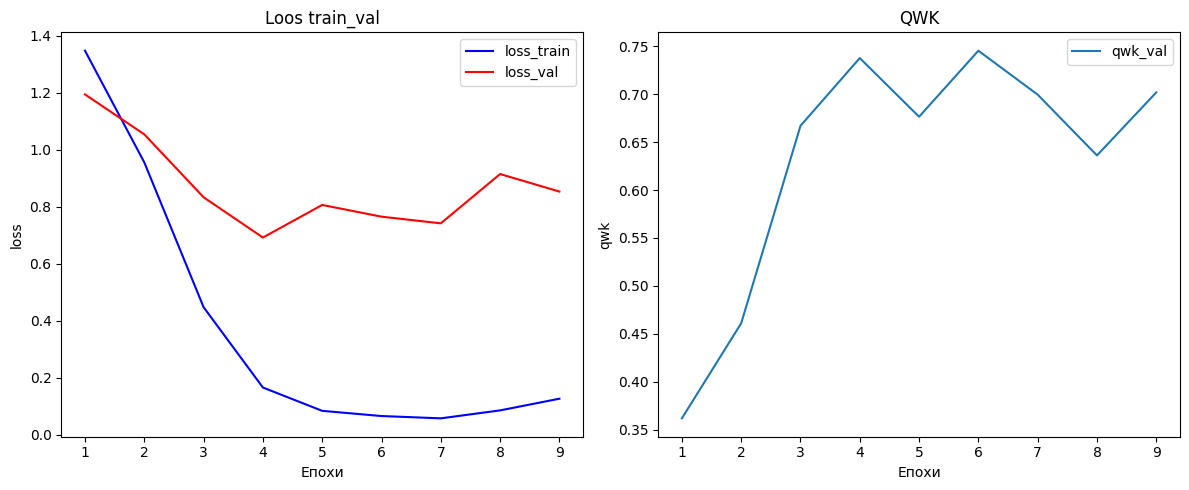

In [42]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss function
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='loss_train')  
plt.plot(epochs, val_losses, 'r-', label='loss_val')   
plt.title('Loos train_val')
plt.xlabel('Епохи')
plt.ylabel('loss')
plt.legend()

# Kappa graph
plt.subplot(1, 2, 2)
plt.plot(epochs, val_kappas,  label='qwk_val')  
plt.title('QWK')
plt.xlabel('Епохи')
plt.ylabel('qwk')
plt.legend()

plt.tight_layout()  
plt.show() 

#### 9.2. Custom quadratic weighted kappa

In [43]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings
    

def custom_quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [44]:
custom_qwk = custom_quadratic_weighted_kappa(val_labels, val_predictions)
print("QWK on validation dataset: ", custom_qwk)

QWK on validation dataset:  0.7453141610250097


### Conclusion:
As can be seen from the learning curve analysis, the model starts to overfeat already after the forth epoch. This is due to the model being too complex for such a small dataset. To solve this problem, you can try to partially freeze the layers that are responsible for embedding text and graphic information.